## Compute Average NDVI in H3 Hexagons for Ljubljana Using Copernicus Sentinel-2 Data

This script calculates the average **Normalized Difference Vegetation Index (NDVI)** within **H3 hexagons** of resolution 13 over the city of **Ljubljana**. The NDVI is derived from the **Copernicus Sentinel-2** satellite imagery data, which provides high-resolution, multispectral images for environmental monitoring.

### Features:
- **Geospatial Analysis**: The script utilizes H3 hexagons to segment the area of interest (Ljubljana) for spatial analysis.
- **NDVI Calculation**: NDVI is computed from Sentinel-2's Red and Near-Infrared (NIR) bands, which helps in assessing vegetation health and land cover.
- **Efficient Processing**: The script aggregates NDVI values over each H3 hexagon, providing a detailed analysis of vegetation distribution in the region.

### Data Source:
- **Copernicus Sentinel-2**: 
  - **Date**: The data used for this analysis is from **July 17, 2024**, captured by the Sentinel-2 satellite (less than 8% cloud coverage and summer vegetation).
  - **Resolution**: The imagery has a spatial resolution of **10 meters**, allowing for detailed and accurate analysis of land cover and vegetation.


In [1]:
# clip out area with Ljubljana

import rasterio
from rasterio.mask import mask
from shapely.geometry import box, mapping
from pyproj import Transformer
import os

# "EPSG:32633" = UTM zone 33N (meters as units in Copernicus JP2 files)
# wgs84_proj = "EPSG:4326" = WGS84 coordinate system (degrees for longitude and latitude)

def transform_bbox(bbox, from_crs="EPSG:4326", to_crs="EPSG:32633"): 
    ''' Transform bounding box from coordinate system to meters'''

    transformer = Transformer.from_crs(from_crs, to_crs, always_xy=True)  # Transform from WGS84 coordinate system to UTM zone 33N
    minx, miny = transformer.transform(bbox[0], bbox[1])  # bbox[0] = min_lon, bbox[1] = min_lat
    maxx, maxy = transformer.transform(bbox[2], bbox[3])  # bbox[2] = max_lon, bbox[3] = max_lat
    return (minx, miny, maxx, maxy)

def clip_jp2(jp2_path, bbox_wgs84, output_path):
    # Transform WGS84 bbox to UTM (EPSG:32633)
    bbox_utm = transform_bbox(bbox_wgs84) 

    # Create a polygon from the UTM bbox
    geom = box(*bbox_utm)
    geojson_geom = [mapping(geom)]

    with rasterio.open(jp2_path) as src:
        out_image, out_transform = mask(src, geojson_geom, crop=True)
        out_meta = src.meta.copy()

    # Update metadata
    out_meta.update({
        "driver": "JP2OpenJPEG",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Save clipped image
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(out_image)

# Bounding box in WGS84 (min_lon, min_lat, max_lon, max_lat)
bbox_wgs84 = (14.408617, 45.974064, 14.755332, 46.145997) 

# Paths to the JP2 files for Red and NIR bands
red_band_path = '/home/iva/Documents/ostalo/ARNES_hackatlon/2025//S2B_MSIL2A_20220719T095559_N0510_R122_T33TVM_20240717T224534.SAFE/GRANULE/L2A_T33TVM_A028033_20220719T095747/IMG_DATA/R10m//T33TVM_20220719T095559_B04_10m.jp2'  
nir_band_path = '/home/iva/Documents/ostalo/ARNES_hackatlon/2025//S2B_MSIL2A_20220719T095559_N0510_R122_T33TVM_20240717T224534.SAFE/GRANULE/L2A_T33TVM_A028033_20220719T095747/IMG_DATA/R10m/T33TVM_20220719T095559_B08_10m.jp2' 

# Output paths for the clipped JP2 files
red_band_path_out = '/home/iva/Documents/ostalo/ARNES_hackatlon/2025//S2B_MSIL2A_20220719T095559_N0510_R122_T33TVM_20240717T224534.SAFE/T33TVM_20220719T095559_B04_10m_ljubljana.jp2' 
nir_band_path_out = '/home/iva/Documents/ostalo/ARNES_hackatlon/2025//S2B_MSIL2A_20220719T095559_N0510_R122_T33TVM_20240717T224534.SAFE/T33TVM_20220719T095559_B08_10m_ljubljana.jp2' 

# Crop red band and NIR band JP2 files
clip_jp2(red_band_path, bbox_wgs84, red_band_path_out)
clip_jp2(nir_band_path, bbox_wgs84, nir_band_path_out)





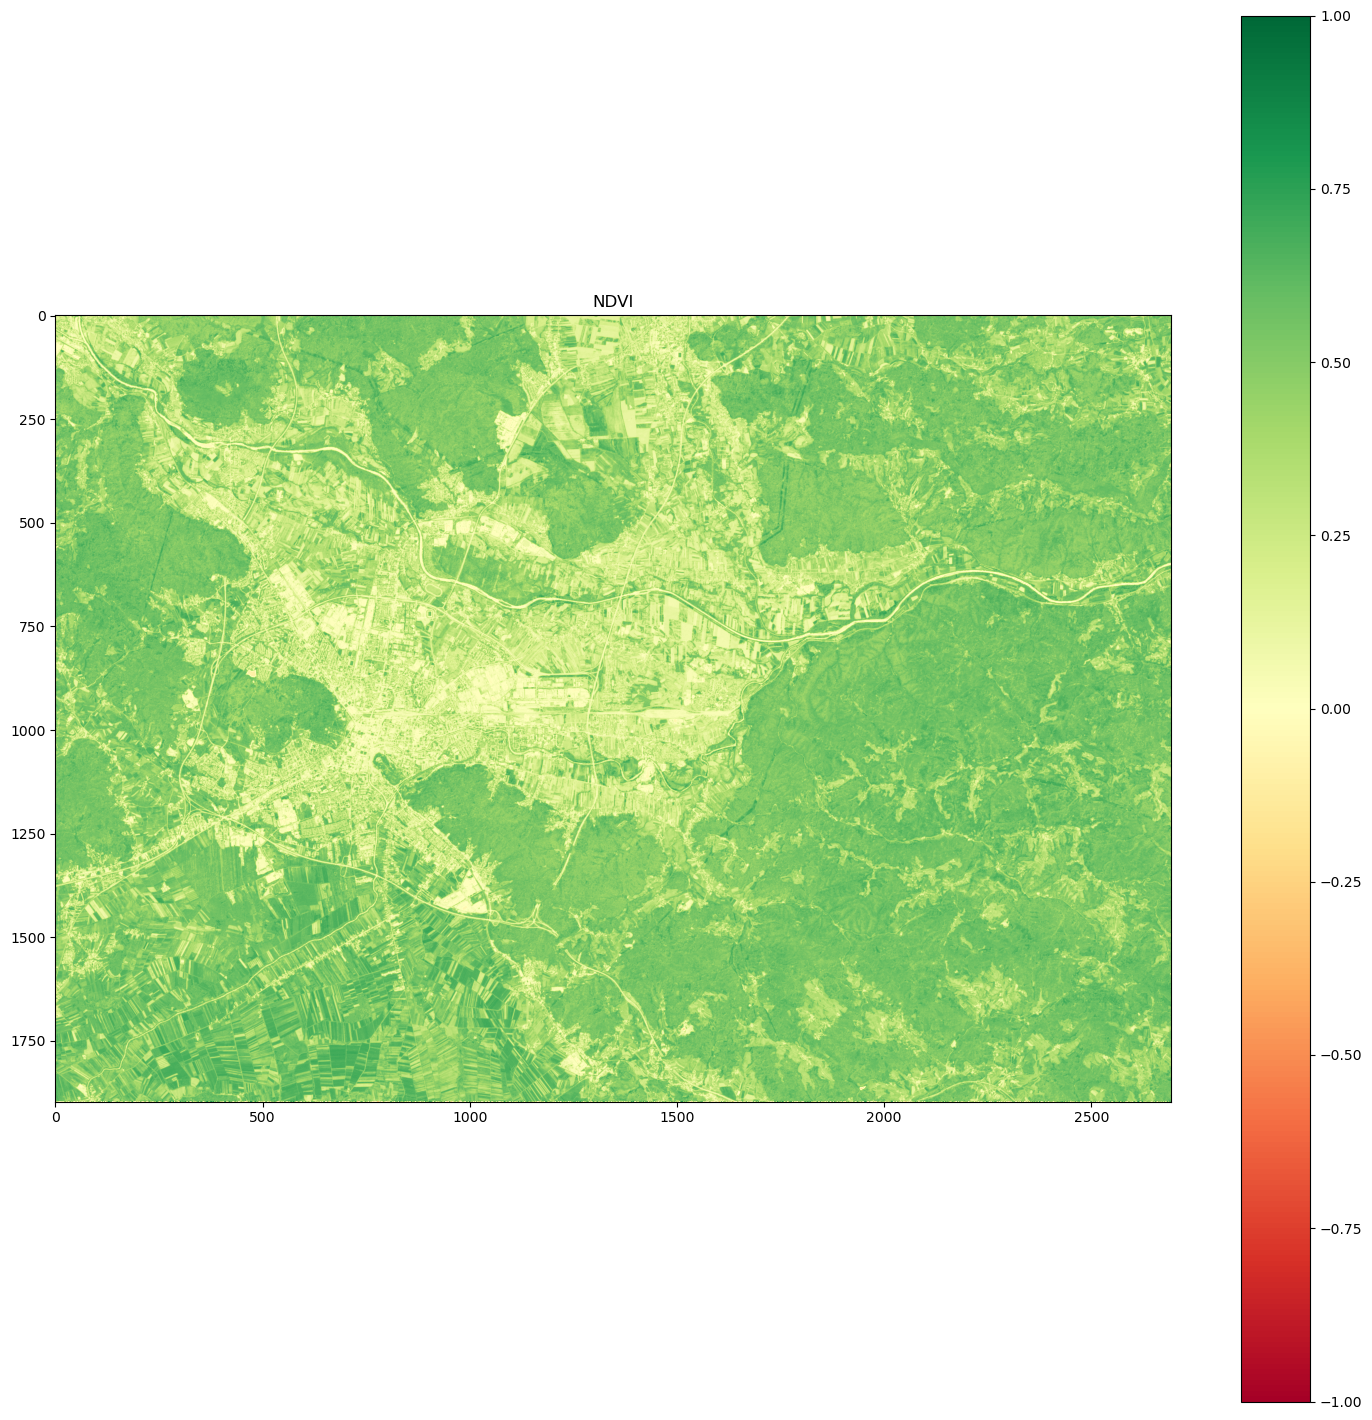

In [2]:
# Compute NDVI for Ljubljana

import rasterio
import numpy as np
import matplotlib.pyplot as plt

import rasterio
import numpy as np
import matplotlib.pyplot as plt

def compute_ndvi(red_band_path, nir_band_path, epsilon=1e-10):
    '''Compute normalized difference vegetation index (NDVI) based on red and NIR band'''
    
    # Open the Red and NIR bands
    with rasterio.open(red_band_path) as red_src:
        red = red_src.read(1).astype('float32')  # Read the first band (Red) and convert uint16 (16-bit unsigned integers)to float
        transform = red_src.transform  # Get the transform for geo-coordinates

    with rasterio.open(nir_band_path) as nir_src:
        nir = nir_src.read(1).astype('float32')  # Read the first band (NIR) and convert uint16 (16-bit unsigned integers)to float
 
    # Calculate NDVI: (NIR - Red) / (NIR + Red), avoid division by zero by adding epsilon
    ndvi = (nir - red) / (nir + red + epsilon)

    return ndvi, transform

# Paths to the JP2 files for Red and NIR bands with 10m resolution
red_band_path = '/home/iva/Documents/ostalo/ARNES_hackatlon/2025//S2B_MSIL2A_20220719T095559_N0510_R122_T33TVM_20240717T224534.SAFE/T33TVM_20220719T095559_B04_10m_ljubljana.jp2'  # (Band 4) = 665 nm
nir_band_path = '/home/iva/Documents/ostalo/ARNES_hackatlon/2025//S2B_MSIL2A_20220719T095559_N0510_R122_T33TVM_20240717T224534.SAFE/T33TVM_20220719T095559_B08_10m_ljubljana.jp2'  # (Band 8) = 842 nm

# Compute NDVI
ndvi, transform = compute_ndvi(red_band_path, nir_band_path)

# Plot the NDVI result
plt.figure(figsize=(18, 18))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI')
plt.show()


In [3]:
ndvi_min = np.nanmin(ndvi)
ndvi_max = np.nanmax(ndvi)

print(f"NDVI min: {ndvi_min:.4f}")
print(f"NDVI max: {ndvi_max:.4f}")

NDVI min: -1.0000
NDVI max: 1.0000


In [4]:
# Compute average NDVI per H3 cell

from pyproj import Transformer
import h3
import numpy as np
import rasterio

def get_h3_cell(lat, lon, resolution=13):
    return h3.latlng_to_cell(lat, lon, resolution)

def compute_avg_ndvi_in_h3(ndvi, transform, resolution=11): 
    '''Compute average NDVI in H3 cell''' 
    
    rows, cols = np.indices(ndvi.shape)

    # Convert pixel indices to UTM coordinates (x, y)
    xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')
    xs = np.array(xs)
    ys = np.array(ys)

    # Reproject UTM (EPSG:32633) to WGS84 (EPSG:4326)
    transformer = Transformer.from_crs("EPSG:32633", "EPSG:4326", always_xy=True)
    lons, lats = transformer.transform(xs, ys)

    # Flatten arrays
    lats = lats.flatten()
    lons = lons.flatten()
    ndvi_flat = ndvi.flatten()

    # Dictionary to store NDVI values for each H3 cell
    h3_cell_ndvi = {}

    for lat, lon, value in zip(lats, lons, ndvi_flat):
        if np.isnan(value):
            continue  # Skip no-data pixels

        h3_cell = get_h3_cell(lat, lon, resolution)

        if h3_cell not in h3_cell_ndvi:
            h3_cell_ndvi[h3_cell] = []

        h3_cell_ndvi[h3_cell].append(value)

    # Compute average NDVI for each H3 cell
    avg_ndvi = {
        cell: np.mean(values)
        for cell, values in h3_cell_ndvi.items()
    }

    return avg_ndvi

# resolution 11: Average Hexagon Area (km2): 0.0021496, Average Hexagon Edge Length (km): 0.024910561
avg_ndvi_h3 = compute_avg_ndvi_in_h3(ndvi, transform, resolution=13)

# Print some H3 cells and their average NDVI values
for cell, avg in list(avg_ndvi_h3.items())[:5]:
    print(f"{cell}: {avg:.4f}")


8d1e128c98ced7f: -1.0000
8d1e128c98ce8bf: 0.2371
8d1e128c98cebbf: 0.1964
8d1e128c98cea3f: 0.2436
8d1e128c98cea7f: 0.2907


In [ ]:
# Save as GeoJSON

import geopandas as gpd
from shapely.geometry import Polygon
import h3

def h3_to_polygon(h3_index):
    """Convert H3 index to shapely Polygon (lat/lon)."""

    boundary = h3.cell_to_boundary(h3_index)
    return Polygon([(lng, lat) for lat, lng in boundary])  # reverse order of lat and long

def ndvi_h3_to_gdf(avg_ndvi_h3):
    """Convert NDVI H3 dictionary to GeoDataFrame."""
    
    records = []

    for h3_cell, ndvi_value in avg_ndvi_h3.items():
        poly = h3_to_polygon(h3_cell)
        records.append({
            'h3_index': h3_cell,
            'avg_ndvi': ndvi_value,
            'geometry': poly
        })

    gdf = gpd.GeoDataFrame(records, crs='EPSG:4326')
    return gdf

# Convert to GeoDataFrame
gdf = ndvi_h3_to_gdf(avg_ndvi_h3)


# Export to GeoJSON
gdf.to_file("/home/iva/Documents/ostalo/ARNES_hackatlon/2025/ndvi_h3_lj_11.geojson", driver="GeoJSON")

# Export to Shapefile (binary - smaller but not good for web apps)
#gdf.to_file("ndvi_h3_shapefile.shp", driver="ESRI Shapefile")


In [ ]:
print(gdf[['avg_ndvi']].describe())

           avg_ndvi
count  5.108621e+06
mean   4.348400e-01
std    1.624847e-01
min   -1.000000e+00
25%    3.354790e-01
50%    4.891843e-01
75%    5.551437e-01
max    1.000000e+00


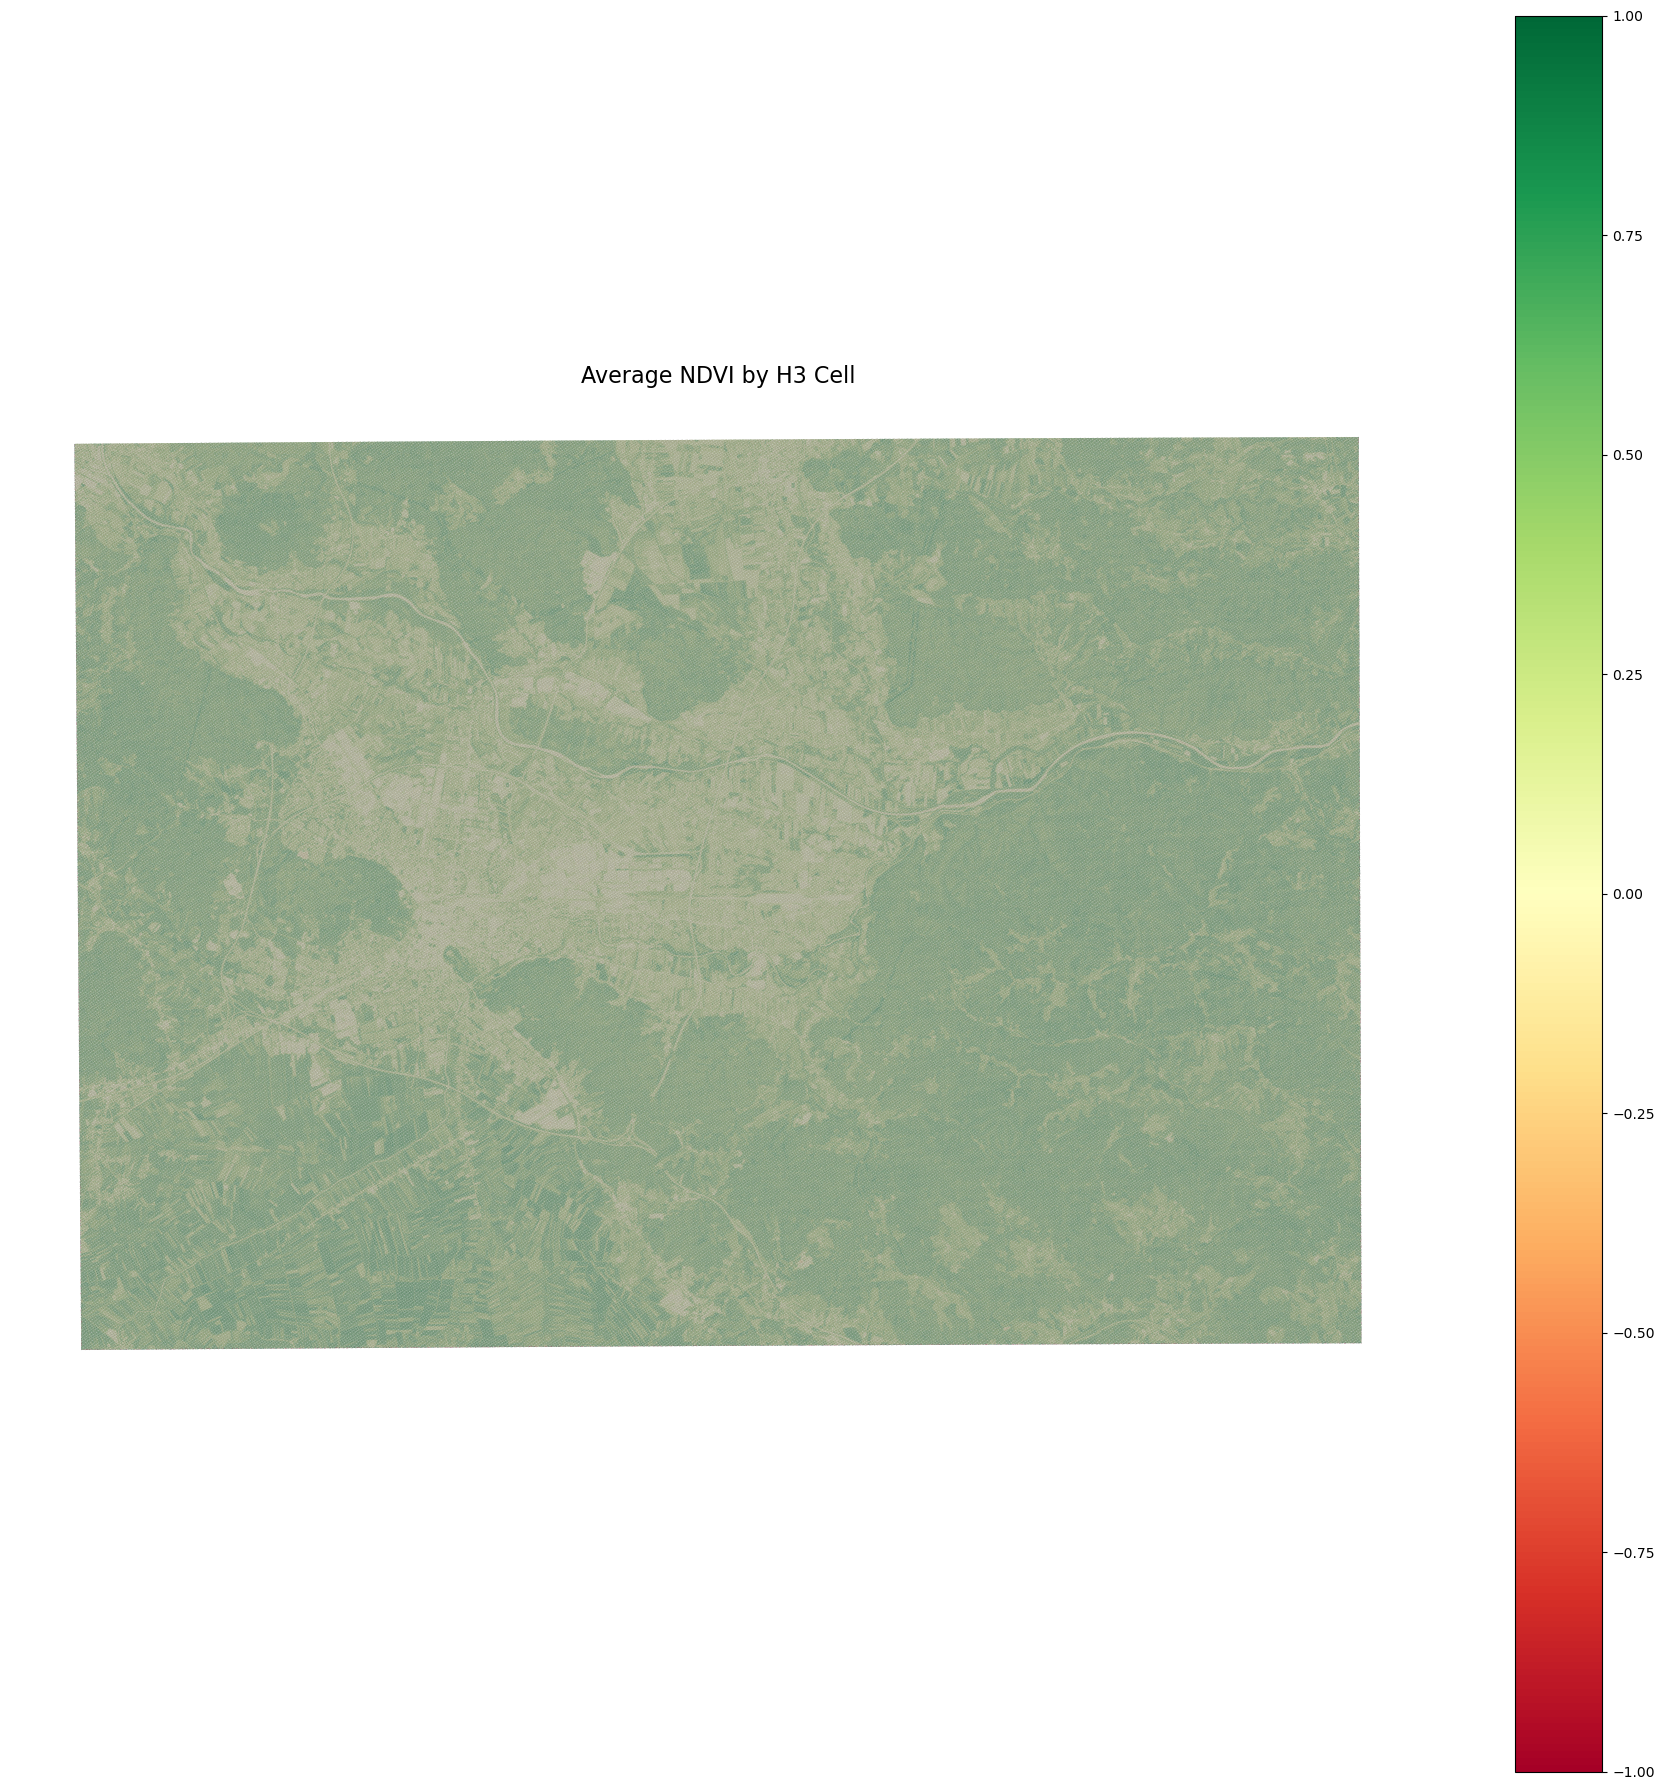

In [ ]:
# Plot average NDVI by H3 hexagons

gdf.plot(
    column='avg_ndvi',
    cmap='RdYlGn',
    legend=True,
    figsize=(18, 18),
    edgecolor='black',
    linewidth=0.05, # or it's all black because of high H3 resolution
)
plt.title("Average NDVI by H3 Cell", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()